# **Mechanistic-Statistical Modeling with Physics-Informed Hypernetworks: A Toy Example**

**Author**:  *Mohamed BADI*
  
**Project Info**: This notebook is part of a research project on integrating Mechanistic-Statistical models with modern deep learning architectures. It presents a comprehensive approach using the Verhulst evolution model for population dynamics, coupled with hypernetworks in a physics-informed framework.

**Date**: May 2025

---

#### **Importing essentials**

In [ ]:
# Jax utils
import jax
from jax import random, lax
import jax.numpy as jnp
from functools import partial
from typing import Tuple
from jaxtyping import Array, Float
import optax

# For the neuronal architectures
import equinox as eqx

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from tqdm import trange

# The jinns library
import jinns
from jinns.loss._DynamicLossAbstract import ODE
from jinns.data import append_param_batch
from jinns.nn._save_load import load_pinn, save_pinn

# Metrics for comparaison
from utils.eval_metrics import (
    l2_relative_error,
    l1_relative_error,
    max_error,
    mean_squared_error,
)

# Finite Differences Jax based solver
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController

# Initialize random key
key = jax.random.PRNGKey(48)
key, subkey = random.split(key)

#### **Introduction**

In this notebook we begin with a realtively simple Mechanisitc-Statistical model to emphasise the methodological aspects of our research. The notebook is divided into two main sections. 

**1. Forward Problem**: Learning the solution of a classical ODE, the Verhulst model, using a Physics-Informed Hypernetwork (referred to as *HyperPINN*). We analyse the optimization behavior and estabilish comparaison metrics to assess the quality of the learned approximation. 

**2. Inverse Problem**: Using the trained model (referred to as the *metamodel*) to infer the ODE parameters from noisy observations of the true solution, within a Bayesian setting.

## **First part: HyperPINNs as a metamodel**
### A mechanistic model
We consider the following population dynamics model, where $N(t)$ is the population size at time $t$, starting from $N_0$:
$$
\left\{
\begin{align}
\frac{\partial N(t)}{\partial t} &= r N(t)\left(1-\frac{N(t)}{K}\right) \qquad t \in [0,T_{max}] \\
N\left(0\right) &= N_0
\end{align}
\right.
$$

Using time normalization, we solve:

$$
\left\{
\begin{align*}
\frac{\partial \hat{N}(t)}{\partial t} &= T_{max} * r\hat{N}(t) \left(1-\frac{\hat{N}(t)}{K}\right) \qquad t \in [0,1]\\
\hat{N}\left(0\right) &= N_0
\end{align*}
\right.
$$

Where $\hat{N}(t) = N(t*T_{max})$.

### HyperPINNs: an Overview
Vanilla PINNs allow to learn the solution of ODEs/PDEs for fixed parameters, requiring retraining for each new set of parameters - which is computationally expensive, especially for inverse problems (explored in Part 2).

HyperPINNs address this by treating the **weights of the PINN** as a function of the ODE/PDE parameters. This function is learned via an **HyperPINN** as illustrated below.

| 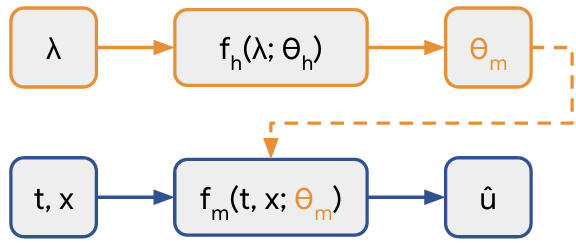 |
| :--: |
| *HyperPINN architecture* |


### The hyperPINN's architecture
We create the neural architectures for both the PINN and the HyperPINN using the JAX-based [`equinox`](https://docs.kidger.site/equinox/) library.\
The HyperPINN takes ODE parameters as input and outputs the weigths of the PINN. The output size is automatically adjusted via the [`jinns`](https://mia_jinns.gitlab.io/jinns/index.html) package. 

In [ ]:
# The main network
eqx_list = (
    (eqx.nn.Linear, 1, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 1),
)

# The hyper network
eqx_list_hyper = (
    (eqx.nn.Linear, 2, 32),  # input is of size 2 for scalar r and scalar K
    (jax.nn.tanh,),
    (eqx.nn.Linear, 32, 32),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 32, 32),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 32, 32),
    (jax.nn.tanh,),
    (
        eqx.nn.Linear,
        32,
        1000,
    ),  # 1000 is a random guess jinns adjust the outputs size automatically
)

key, subkey = random.split(key)

hyperparams = ["r", "K"]
hypernet_input_size = 2

In [ ]:
u, init_nn_params = jinns.nn.HyperPINN.create(
    key=subkey,
    eqx_list=eqx_list,
    eq_type="ODE",
    hyperparams=hyperparams,
    hypernet_input_size=hypernet_input_size,
    eqx_list_hyper=eqx_list_hyper,
)

## **Data generation**

#### Create a DataGenerator Object
We generate a **uniform** main sample of `100000` collocation points from we take batches of size `1000`. Points are sampled from $[0,1]$, since we have already normalized the equation. We stress that after each `epoch` the `DataGenerator` performs a random reshufling of the data.

In [ ]:
nt = 100000
batch_size = 1000
method = "uniform"
tmin = 0
tmax = 1

Tmax = 50
train_data = jinns.data.DataGeneratorODE(
    key=subkey,
    nt=nt,
    tmin=tmin,
    tmax=tmax,
    temporal_batch_size=batch_size,
    method=method,
)

#### Additional batch for the parameters
We do the same for the ODE's parameters and we sample $r$ and $K$ respectively in the intervals $[0.05, 0.5]$ and $[8,15]$. The batch size used for the equation parameters should match the collocation point batch.

In [ ]:
method = "uniform"
key, subkey = random.split(key)
np = 100000
param_batch_size = 1000
param_train_data = jinns.data.DataGeneratorParameter(
    subkey,
    np,
    param_batch_size,
    {"r": (0.05, 0.5), "K": (8, 15)},
    method,
)

#### Parameter initialization

In [ ]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params, eq_params={**param_train_data.get_batch()[1]}
)

## **Loss construction for the ODE**

The total loss in this case is composed of **physics loss** term and an **initial condition** term.

* **Physics loss**: This loss corresponds to the dynamics of the considered ODE/PDE.

$$
\begin{equation}
\mathcal{L}_{\text{physics}} = \frac{1}{N_f} \sum_{i=1}^{N_f} \left| \mathbf{r}_{\theta}\left(x_f^{(i)}, t_f^{(i)}\right) \right|^2
\end{equation}
$$

where $\mathbf{r}_{\theta}$ is the residual of the PDE/ODE. $\mathbf{r}_{\theta}:=\frac{\partial u_\theta}{\partial t}-r u_\theta\left(1-\frac{u_\theta}{K}\right)$) in our case. And $(x_f^{(i)}, t_f^{(i)})$ are the collocation points.

* **Initial loss**

$$
\begin{equation}
\mathcal{L}_{\text{Initial}} = \left| u_{\theta}(0) - N_0 \right|^2
\end{equation}
$$

The total loss is weight sum of the two losses above:

$$
    \mathcal{L}\left(\theta\right) = \mathcal{L}_{\text{physics}} + \lambda \mathcal{L}_{\text{Initial}}
$$

We define the loss dynamical loss by inheriting from the class `ODE`

In [ ]:
class Logistic_reparametrized(ODE):
    r"""
    Return the Logistic loss term.
    """

    def __init__(self, Tmax=1, eq_params_heterogeneity=None):
        super().__init__(Tmax=Tmax, eq_params_heterogeneity=eq_params_heterogeneity)

    def equation(self, t, u, params):
        u_ = lambda t: u(t, params)[0]
        du_dt = jax.grad(u_)(t)[0]
        return du_dt + self.Tmax * (
            -params.eq_params["r"]
            * u(t, params)
            * (1 - u(t, params) / params.eq_params["K"])
        )


Logistic_dynamic_loss = Logistic_reparametrized(Tmax=Tmax)

#### Loss weights

Since the renormalization introduces a `Tmax` in front of the term of the ODE, we multiply the initial condition loss by `Tmax` to balance the total loss.

In [ ]:
loss_weights = jinns.loss.LossWeightsODE(
    dyn_loss=1, initial_condition=1 * Tmax, observations=0
)

loss = jinns.loss.LossODE(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=Logistic_dynamic_loss,
    initial_condition=(0, 1),
    params=init_params,
)

#### Sanity check
We print the losses for the initial parameters to verify their magnitudes.

In [ ]:
losses_and_grad = jax.value_and_grad(loss, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params,
    append_param_batch(train_data.get_batch()[1], param_train_data.get_batch()[1]),
)

# Sanity check
l_tot, d = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

total loss: 40.61
Individual losses: {'dyn_loss': '5.94', 'initial_condition': '34.67', 'observations': '0.00'}


## **Learning the neural network parameters**

The learning process here consider known equation params `eq_params`. We thus only update `nn_params`. Then the total loss is minimized via gradient descent.

In [ ]:
params = init_params
tx = optax.adamw(learning_rate=1e-3)
n_iter = 100000

#### The training loop

Here we use the `jinns.solve` method to train the HyperPINN

In [ ]:
start = time.time()
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _, _, _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    param_data=param_train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
)
end = time.time()


Compilation took
 14.428095579147339 

[train] Iteration 0: loss value = 40.44322967529297
[train] Iteration 1000: loss value = 18.313247680664062
[train] Iteration 2000: loss value = 15.882028579711914
[train] Iteration 3000: loss value = 17.991649627685547
[train] Iteration 4000: loss value = 16.334203720092773
[train] Iteration 5000: loss value = 13.947280883789062
[train] Iteration 6000: loss value = 14.307479858398438
[train] Iteration 7000: loss value = 14.498756408691406
[train] Iteration 8000: loss value = 16.605186462402344
[train] Iteration 9000: loss value = 16.499378204345703
[train] Iteration 10000: loss value = 16.11028289794922
[train] Iteration 11000: loss value = 15.595856666564941
[train] Iteration 12000: loss value = 16.46670150756836
[train] Iteration 13000: loss value = 18.444324493408203
[train] Iteration 14000: loss value = 14.365588188171387
[train] Iteration 15000: loss value = 18.5258846282959
[train] Iteration 16000: loss value = 15.659162521362305
[train] I

In [ ]:
time_training = end - start
print("Time training the metamodel", time_training)

Time training the metamodel 171.65743112564087


#### Save the HyperPINN
We save the HyperPINN using the `save_pinn` function from `jinns` for later use in the inverse problem

In [ ]:
filename = f"./metamodel-logistic-{n_iter}iter"
kwargs_creation = {
    "key": subkey,
    "eqx_list": eqx_list,
    "eq_type": "ODE",
    "hyperparams": hyperparams,
    "hypernet_input_size": hypernet_input_size,
    "eqx_list_hyper": eqx_list_hyper,
}
save_pinn(filename, u, params, kwargs_creation)

#### Loss tracking
Here we plot the losses in `log10` scale

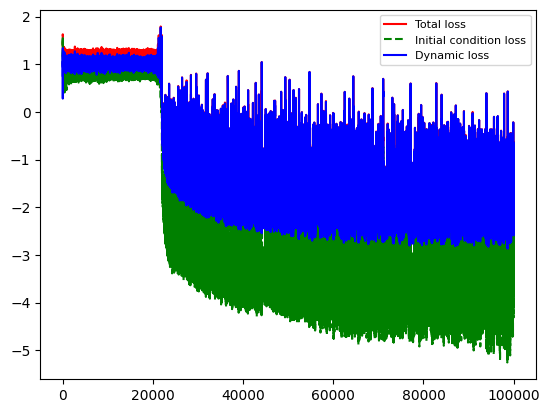

In [ ]:
plt.plot(
    jnp.arange(n_iter), jnp.log10(total_loss_list), color="red", label="Total loss"
)
plt.plot(
    jnp.arange(n_iter),
    jnp.log10(loss_by_term_dict["initial_condition"]),
    linestyle="dashed",
    color="green",
    label="Initial condition loss",
)
plt.plot(
    jnp.arange(n_iter),
    jnp.log10(loss_by_term_dict["dyn_loss"]),
    color="blue",
    label="Dynamic loss",
)
plt.legend(loc="upper right", fontsize=8)
plt.show()

### **Results and evaluation metrics**

#### Some plots

We plot HyperPINN solution againt the exact solution for the following grid of parameters:

* `r_values = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]`
* `K_values = [8, 10, 15]`

18 plots of comparison have been generated

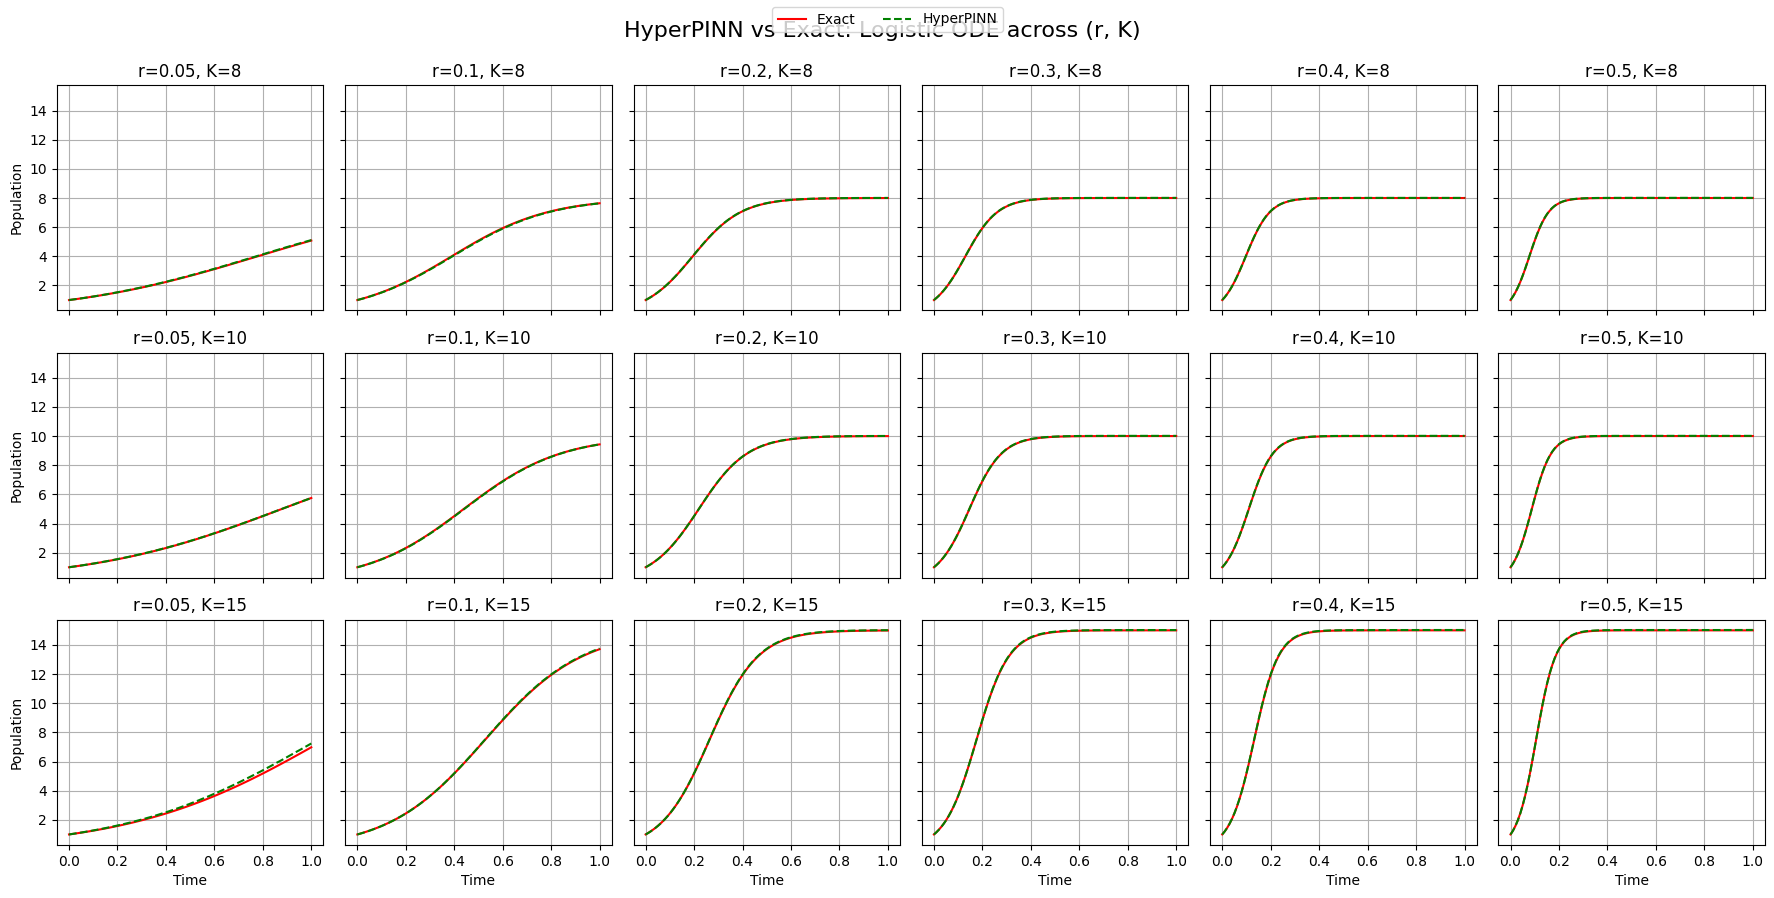

In [ ]:
# Initial condition
N_0 = 1

# Time domain
nt = 100
times = jnp.linspace(0, Tmax, nt) / Tmax


# Ground truth function
def N_exact(t, beta):
    N_0, r, K = beta
    return (K * N_0 * jnp.exp(r * t)) / (K + N_0 * (jnp.exp(r * t) - 1))


# Parameter grid (6 r-values × 3 K-values)
r_values = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
K_values = [8, 10, 15]

# Create subplots: 3 rows (K), 6 columns (r)
fig, axes = plt.subplots(
    nrows=len(K_values), ncols=len(r_values), figsize=(18, 9), sharex=True, sharey=True
)

for i, K_val in enumerate(K_values):
    for j, r_val in enumerate(r_values):
        ax = axes[i, j]

        # Exact solution
        exact = N_exact(times * Tmax, beta=(N_0, r_val, K_val))

        # Network prediction
        sizes_u = jax.vmap(u, in_axes=(0, None))(
            times,
            jinns.parameters.Params(
                nn_params=params.nn_params,
                eq_params={"r": jnp.array([r_val]), "K": jnp.array([K_val])},
            ),
        ).squeeze()
        # Plot on the correct subplot
        ax.plot(times, exact, label="Exact", color="red")
        ax.plot(times, sizes_u, label="HyperPINN", linestyle="dashed", color="green")
        ax.set_title(f"r={r_val}, K={K_val}")
        ax.grid(True)
        if i == len(K_values) - 1:
            ax.set_xlabel("Time")
        if j == 0:
            ax.set_ylabel("Population")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("HyperPINN vs Exact: Logistic ODE across (r, K)", fontsize=16)
plt.show()

### Evaluation metrics

Generally, we choose several metrics that are commonly used in literature that apply to all methods and problems. We suppose that $\mathbf{y} = \left(y_i\right)_{i=1}^n$ is the prediction and $\mathbf{y'}=\left(y_i^{'}\right)_{i=1}^n$ is ground truth, where $n$ is the number of testing examples. Specifically, we use $\ell_2$ relative error (L2RE), and $\ell_1$ relative error (L1RE) which are among the most commonly used metrics to assess the global accuray of the solution,

$$
   \text{L2RE} = \sqrt{\frac{\sum_{i=1}^{n} (y_i - y_i^{'})^2}{\sum_{i=1}^{n} y_i^{'2}}}. \quad  \text{L1RE} = \frac{\sum_{i=1}^{n} |y_i - y_i^{'}|}{\sum_{i=1}^{n} |y_i|}
$$

We also compute max error (mERR) and mean square error (MSE).

$$
    \text{mERR} = \max_i |y_i - y_i^{'}| \quad \text{MSE} = \frac{1}{n} \sum_{i = 1}^n (y_i - y_i^{'})^2
$$

We define a grid for the ODE's parameters using `jnp.meshgrid`.

In [ ]:
r = jnp.linspace(0.05, 0.5, 50)
k = jnp.linspace(8, 15, 50)
R, K = jnp.meshgrid(r, k)
rk = jnp.stack([R.ravel(), K.ravel()], axis=1)

We define the function `compute_errors` that computes the four metrics for each couple of parameters $(r,K)$

In [ ]:
def compute_errors(r_val, K_val, u):
    # Exact solution
    exact = N_exact(times * Tmax, beta=(N_0, r_val, K_val))

    # PINN prediction
    sizes_u = jax.vmap(u, in_axes=(0, None))(
        times,
        jinns.parameters.Params(
            nn_params=params.nn_params,
            eq_params={"r": jnp.array([r_val]), "K": jnp.array([K_val])},
        ),
    ).squeeze()

    return jnp.array(
        [
            l2_relative_error(sizes_u, exact),
            l1_relative_error(sizes_u, exact),
            mean_squared_error(sizes_u, exact),
            max_error(sizes_u, exact),
        ]
    )

We compute these metrics for each point in the parameter grid

In [ ]:
errors = jax.vmap(compute_errors, in_axes=(0, 0, None))(R.ravel(), K.ravel(), u)
errors = errors.T.reshape(4, *R.shape)  # shape: (4, 50, 50)

L2, L1, MSE, MAX = errors

We plot some contour plots for the four of them

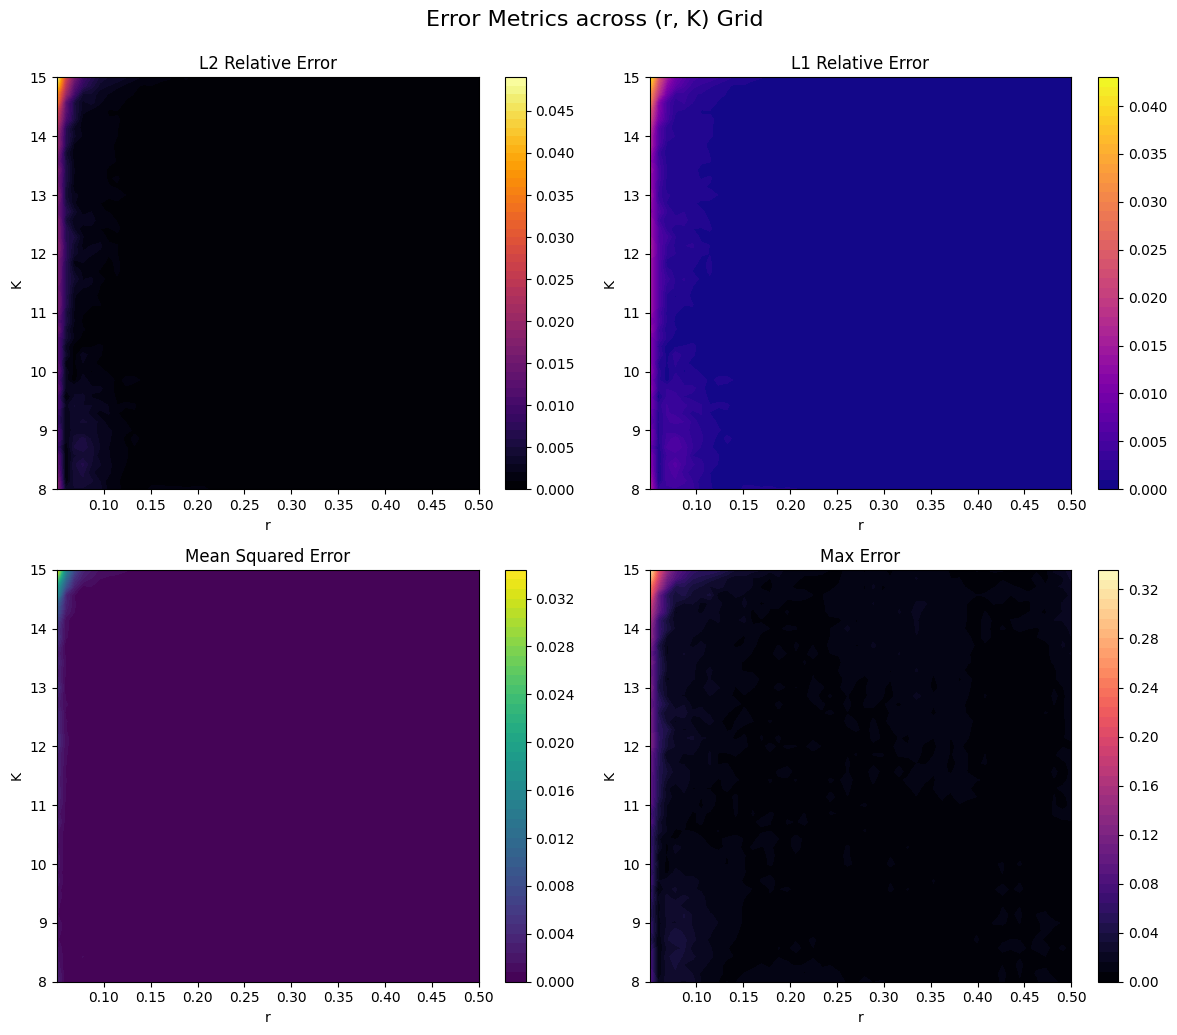

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

titles = ["L2 Relative Error", "L1 Relative Error", "Mean Squared Error", "Max Error"]
error_maps = [L2, L1, MSE, MAX]
cmaps = ["inferno", "plasma", "viridis", "magma"]

for ax, err, title, cmap in zip(axes.ravel(), error_maps, titles, cmaps):
    c = ax.contourf(R, K, err, levels=50, cmap=cmap)
    fig.colorbar(c, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("r")
    ax.set_ylabel("K")

plt.tight_layout()
plt.suptitle("Error Metrics across (r, K) Grid", fontsize=16, y=1.03)
plt.show()

## **Second part: statistical modeling using the hyperPINN**

#### Loading the HyperPINNN

In [ ]:
u_trained, params = load_pinn(
    filename="./metamodel-logistic-100000iter", type_="hyperpinn"
)

## **A Mechanico-Statistical model**
### **The mechanistic model**
Here we consider a population whose dynamics follow the logistic model ODE. The population size $N(t)$ evolves over time due to two types of events: births and deaths. Mortality increases with population size. The function $N(t)$ is described by the following ODE: 

$$
N'(t) = rN(t)\left(1-\frac{N(t)}{K}\right), \quad t \geq 0
$$

where $r>0$ est the intrinsic growth rate of the population and $K$ is the carrying capacity. The solution of this ODE is given by, with initial condition $N(0) = N_0 = 1$, is:
$$
N(t) = \frac{KN_0 e^{rt}}{K + N_0 (e^{rt} - 1)}, \quad t \geq 0
$$

#### Parameters

In [ ]:
N_0 = 1
r = 0.1
K = 10
sigma = 0.1
theta_init = (0.2, 13.0, 0.4)  # (r, K, sigma)

#### Exact Solution Definition

In [ ]:
def N_exact(t, beta):
    r, K = beta
    return (K * N_0 * jnp.exp(r * t)) / (K + N_0 * (jnp.exp(r * t) - 1))

#### True Measurments

In [ ]:
nt = 100  # 1000
Tmax = 50  # 100
times = jnp.linspace(0, Tmax, nt)  # t1, ...,tI
sizes = N_exact(times, beta=(r, K))  # N(t1), ...,N(tI)

#### Plot

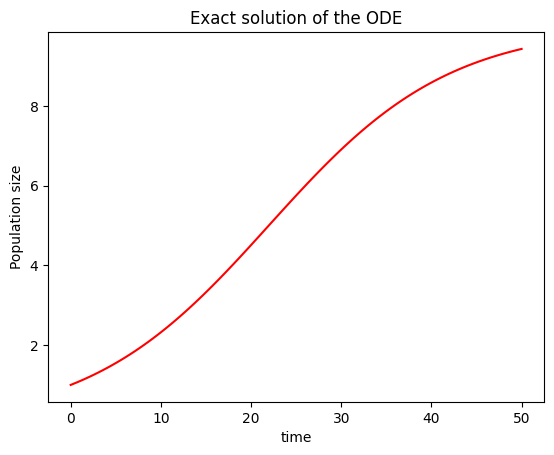

In [ ]:
assert len(times) == len(sizes)
plt.plot(times, sizes, "red")
plt.xlabel("time")
plt.ylabel("Population size")
plt.title("Exact solution of the ODE")
plt.show()

#### Using an ODE solver: we use `diffrax`

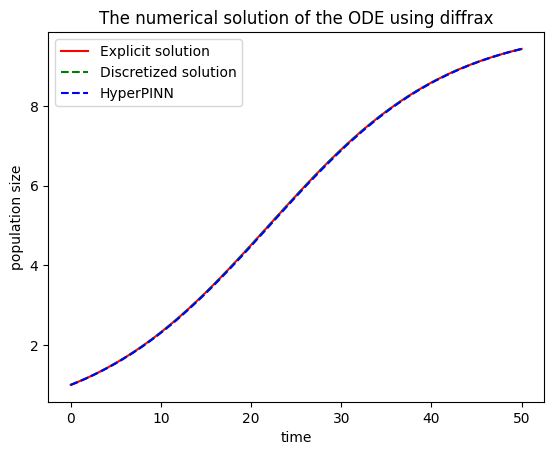

In [ ]:
def Vectorial_N_ode(T: Array, beta) -> Array:
    def vector_field(t, y, args):
        r, K = args
        return r * y * (1 - y / K)

    term = ODETerm(vector_field)
    solver = Dopri5()
    saveat = SaveAt(ts=T)
    stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

    params = beta[0:2]  # r, K
    sol = diffeqsolve(
        term,
        solver,
        t0=0,
        t1=T[-1],
        dt0=None,
        args=params,
        y0=N_0,
        saveat=saveat,
        stepsize_controller=stepsize_controller,
    )
    return sol.ys


def N_ode(t: Float, beta) -> Array:
    def vector_field(t, y, args):
        r, K = args
        return r * y * (1 - y / K)

    term = ODETerm(vector_field)
    solver = Dopri5()  # Dormand--Prince
    saveat = SaveAt(ts=jnp.array([t]))
    stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

    params = beta[0:2]  # r, K

    sol = diffeqsolve(
        term,
        solver,
        t0=0,
        t1=t,
        dt0=None,
        args=params,
        y0=N_0,
        saveat=saveat,
        stepsize_controller=stepsize_controller,
    )
    return sol.ys


Vectorised_N_ode = jax.vmap(N_ode, in_axes=(0, None))

beta = (r, K)
N_values1 = Vectorial_N_ode(times, beta)
N_values2 = Vectorised_N_ode(times, beta)
N_values3 = jax.vmap(u_trained, in_axes=(0, None))(
    times / Tmax,
    jinns.parameters.Params(
        nn_params=params.nn_params,
        eq_params={"r": jnp.array([0.1]), "K": jnp.array([10])},
    ),
).squeeze()

plt.plot(times, N_values2, color="red", label="Explicit solution")
plt.plot(
    times, N_values1, color="green", label="Discretized solution", linestyle="dashed"
)
plt.plot(times, N_values3, color="blue", label="HyperPINN", linestyle="dashed")
plt.title("The numerical solution of the ODE using diffrax")
plt.xlabel("time")
plt.ylabel("population size")
plt.legend()
plt.show()

### **Model for the observation process**
At times $t_1, \dots, t_I > 0$ we have the measurements $y_1, \dots,  y_I$ of the population sizes $N(t_1), \dots, N(t_I)$, except that these observations are made committing some error that we call noise. More formally, we suppose that $y_1, \dots, y_I$ are the realisations of independent Log-normal random variables centered on the true values $N(t_i)$ and with a constant variance $\sigma^2$:

$$
Y_i|N(t_i) \sim Lognormal\left(\log(N(t_i)), \sigma^2\right)
$$

Where we denote by $Y_i$ the random variable and $y_i$ it's realization, and $\sigma^2$ the variance of the error committed when taking the measurements. 

We can rewrite the model, for all $i \in \left\{1, \dots, I\right\}$,

$$
Y_i|t_i \sim Lognormal\left(\log(\eta(t_i, \beta)), \sigma^2\right),
$$
With $\eta(t, \beta) = N(t; r, K, N_0)$ and $\beta = \left(r, K\right)$;

The likelihood of the model is given by:

$$
p(\mathbf{y}|\theta, \mathbf{t}) = \frac{1}{\left(2\pi\sigma^2\right)^{I/2}} \prod_{i = 1}^I \frac{1}{y_i} \exp\left\{-\frac{\left(\log(y_i) - \log(\eta(t_i, \beta))\right)^2}{2\sigma^2}\right\} \mathbf{1}_{\mathbf{y} > 0}
$$
Where $\mathbf{y} = \left(y_1, \dots, y_I\right)$, $\mathbf{t} = \left(t_1, \dots, t_I\right)$ and $\theta = \left(\beta, \sigma\right) = \left(r, K, \sigma\right)$.

#### **Generation of synthetic data**

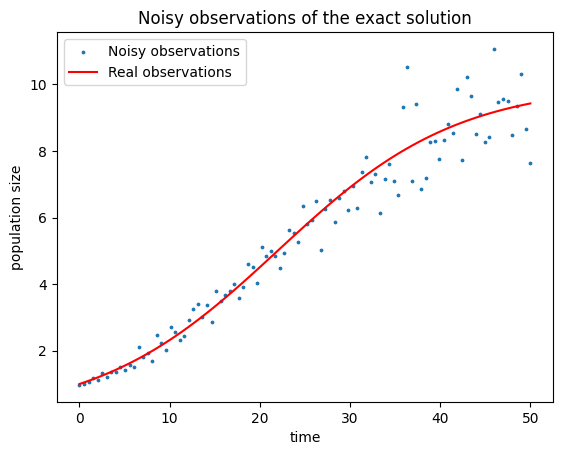

In [ ]:
## Synthetic data with N_0 = 1, r = 0.1, K = 10, sigma = 0.5
eps = jax.random.normal(key, shape=sizes.shape)
log_Y = jnp.log(sizes) + sigma * eps
Y = jnp.exp(log_Y)

plt.scatter(times, Y, s=3, label="Noisy observations")
plt.plot(times, sizes, "red", label="Real observations")
plt.legend(loc="upper left")
plt.title("Noisy observations of the exact solution")
plt.xlabel("time")
plt.ylabel("population size")
plt.show()

In [ ]:
@jax.jit
def log_lognorm_pdf(x, log_mu, sigma):
    """Logarithm of the Log-normal PDF"""
    return jnp.where(
        x > 0,
        -jnp.log(x * sigma * jnp.sqrt(2 * jnp.pi))
        - (jnp.log(x) - log_mu) ** 2 / (2 * sigma**2),
        -jnp.inf,
    )


## Vectorized version using vmap
Vectorized_log_lognorm_pdf = lambda X, log_Mu, fixed_sigma: jnp.sum(
    jax.vmap(log_lognorm_pdf, in_axes=(0, 0, None))(X, log_Mu, fixed_sigma)
)

### **Prior distribution of the parameters choice ?**

Following Soubeyrand and Roques in *Modèles de réaction-diffusion pour l'écologie spatiale* we use the following prior distributions:

$$
\begin{align}
    r &\sim Exp(1), \\
    K &\sim \mathcal{U}_{[0,15]} \\
    \sigma &\sim Exp(1)
\end{align}
$$

The prior distribution is thus given by :

$$
\pi(\theta) = \pi(r,K,\sigma) = \exp\left(-r-\sigma\right)\mathbf{1}_{r>0,\sigma>0}\frac{\mathbf{1}_{0 < K\leq 15}}{15}
$$

The posterior distribution of the parameters is given by:

$$
    p(\theta|\mathbf{y}, \mathbf{t}) = \frac{p(\mathbf{y}|\theta, \mathbf{t}) \cdot \pi(\theta)}{\int_{(\mathbb{R}_+^*)^4} p(\mathbf{y}|\theta, \mathbf{t}) \cdot \pi(\theta) \mu (d\theta)}
$$

In general the normalization constant is hard to compute, and for this we use numerical methods to sample from the posterior distribution.

In [ ]:
@jax.jit
def log_prior_pdf(theta: tuple):
    """
    Logarithm of prior PDF
    """
    r, K, sigma = theta
    return jnp.where(
        (r * K * sigma > 0) & (K <= 15), -r - sigma - jnp.log(15), -jnp.inf
    )


@partial(jax.jit, static_argnames=["solver"])
def log_posterior_pdf(theta: tuple, Y: Array, T: Array, solver: int):
    """
    JAX-compatible log posterior using static `solver` switch.
    """
    beta, sigma = theta[:2], theta[2]

    def case_solver1(_):
        return Vectorised_N_ode(T, beta).squeeze()

    def case_solver2(_):
        return Vectorial_N_ode(T, beta)

    def case_solver3(_):
        # Normalizing time if HyperPINN expects [0,1]
        return jax.vmap(u_trainn_axes=(0, None))(
            T / Tmax,
            jinns.parameters.Params(
                nn_params=params.nn_params,
                eq_params={"r": jnp.array(beta[0]), "K": jnp.array(beta[1])},
            ),
        ).squeeze()

    sizes = lax.switch(
        solver - 1, [case_solver1, case_solver2, case_solver3], operand=None
    )
    log_mu = jnp.log(sizes)

    return Vectorized_log_lognorm_pdf(Y, log_mu, sigma) + log_prior_pdf(theta)

In [ ]:
# Sanitiy check: # THE TIME IS DOUBLED
print(log_posterior_pdf(theta_init, Y, times, solver=1))
%timeit log_posterior_pdf(theta_init, Y ,times, solver = 1).block_until_ready()

print(log_posterior_pdf(theta_init, Y, times, solver=2))
%timeit log_posterior_pdf(theta_init, Y ,times, solver = 2).block_until_ready()

print(log_posterior_pdf(theta_init, Y, times, solver=3))
%timeit log_posterior_pdf(theta_init, Y ,times, solver = 3).block_until_ready()

-276.7185
58.7 ms ± 2.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
-276.71893
58.8 ms ± 1.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
-277.21887
8.11 ms ± 104 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## **The Metropolis-Hastings Algorithm**

The Metropolis-Hastings (MH) algorithm is a Markov Chain Monte Carlo (MCMC) method used to sample from a probability distribution when direct sampling is difficult. In this context, MH can be used to infer the uncertain parameters $N_0$, $r$, $K$ and $\sigma$ from data by sampling from their posterior distribution.

**Goal**: Sample from the posterior distribution:
$$
p(\theta | \mathbf{y}, \mathbf{t}) \propto p(\mathbf{y} | \theta, \mathbf{t}) \cdot \pi(\theta)
$$

### **The algorithm**
1. **Initialize** $\theta_0 = \left(r_0, K_0, \sigma^2_0\right)$
2. For $i = 1$ to $N$:
   - **Propose** $\theta^* \sim q(\theta^* | \theta_i)$ where $q(.| \theta_i)$ is an instrumental transition to be defined.
   - **Compute the ratio**:
     $$
      \alpha\left(\theta^*, \theta_i\right) = \frac{p(\mathbf{y} | \theta^*, \mathbf{t}) \cdot \pi(\theta^*) \cdot q(\theta_i | \theta^*)}{p(\mathbf{y} | \theta_i, \mathbf{t}) \cdot \pi(\theta_i) \cdot q(\theta^* | \theta_i)}
     $$

The normalisation constant just simplifies and if the kernel is symmetric the ratio just simplifies:

$$
\alpha\left(\theta^*, \theta_i\right) = \frac{p(\mathbf{y} | \theta^*, \mathbf{t}) \cdot \pi(\theta^*)}{p(\mathbf{y} | \theta_i, \mathbf{t}) \cdot \pi(\theta_i)}
$$
    

   - **Accept or reject**:
     - Sample $u \sim \mathcal{U}(0,1)$ with $u$ indep from $\theta^*$ 
     - If $u < \alpha$, accept: $\theta_{i+1} = \theta^*$
     - Else, reject: $\theta_{i+1} = \theta_i$

### **Choice of the instrumental transition kernel ?**
We choose to do a random walk on the logarithm of the parameters since the're all strictly positive. Some at step $i$ of the algorithm we write:

$$
\begin{align}
    r_i &= r_{i-1} \cdot \exp(\tau_2 \cdot \xi_{2,i}) \\
    \sigma_i &= \sigma_{i-1} \cdot \exp(\tau_4 \cdot \xi_{4,i}).
\end{align}
$$

In general if we take a prior on $K$ of the form $K\sim \mathcal{U}_{[0,K_{max}]}$ we should make sure that our transitions rely in the same space. For this we consider a random-walk on $logit(\frac{K}{K_{max}})$ instead. At step $i$, the transition writes: 

$$
\Large
K_i = \frac{K_{\text{max}}}{1 - \left(1 - \frac{K_{\text{max}}}{K_{i-1}}\right) \exp\left(\tau_3 \xi_{3,i}\right)}
$$

Where $(\xi_{1,1}, \xi_{2,1}, \xi_{3,1}, \xi_{4,1}), \dots, (\xi_{1,n}, \xi_{2,n}, \xi_{3,n}, \xi_{4,n})$ are i.i.d $\mathcal{N}(0,1)$. And $\tau_1, \tau_2, \tau_3, \tau_4$ are to be tuned.

In [ ]:
def log_prop(
    theta_current: Tuple, sigmas: Tuple, key
) -> Tuple[Float, Float, Float, Float]:
    """
    Proposal of log parameter using a random walk
    theta_current: the current theta
    sigmas: the variances of the random walks (tau_1, tau_2, tau_3, tau_4)
    """
    ## Keys for generating randomness
    key_r, key_K, key_sigma = jax.random.split(key, 3)
    r, K, sigma = theta_current

    ## Update the parameters with random walk
    r_next = r * jnp.exp(sigmas[0] * jax.random.normal(key_r))
    K_next = 15 / (
        1 - (1 - 15 / K) * jnp.exp(sigmas[1] * jax.random.normal(key_K))
    )  # new transition
    sigma_next = sigma * jnp.exp(sigmas[2] * jax.random.normal(key_sigma))

    theta_next = (r_next, K_next, sigma_next)
    return theta_next


## We jitt the higher level function
# @partial(jax.jit, static_argnames = ['solver'])
def mh_step(theta_current: tuple, sigmas: tuple, Y: Array, T: Array, key, solver):
    """
    This function does the following:
    1. It compute the ratio for the current and the new proposal theta
    2. It accept it or reject it
    """
    key_acceptation, key_proposal = jax.random.split(key, 2)

    ## Generate the next theta using the random walk
    theta_prop = log_prop(theta_current, sigmas, key_proposal)

    ## Compute the ratio
    log_posterior_current = log_posterior_pdf(theta_current, Y, T, solver)
    log_posterior_prop = log_posterior_pdf(theta_prop, Y, T, solver)
    alpha = jnp.exp(log_posterior_prop - log_posterior_current)

    ## Accept or reject the proposal
    u = jax.random.uniform(key=key_acceptation)

    theta_next = jax.tree.map(
        lambda a, b: jax.lax.select(u < alpha, a, b), theta_prop, theta_current
    )
    is_accepted = (u < alpha).astype(jnp.int32)

    return theta_next, alpha, is_accepted

### **MH sampler using a for loop**

In [ ]:
## Using a for loop
def mh_sampler(
    theta_init: tuple, num_samples: int, sigmas: tuple, Y: Array, T: Array, key, solver
):
    """
    mh_sampler: samples from the posterior distribution
    1. Theta_init: the initial parameters
    2. num_samples: The number of samples generated
    3. sigmas: The variances of the random walks (tau_1, tau_2, tau_3, tau_4)
    4. Y: The data
    5. T: times
    6. solver: choose between 1:'Vectorised' and 2:'Vectorial'
    """
    n_accepted = 0
    samples = []
    theta_current = theta_init

    for _ in trange(num_samples, desc="Exploring parameter's space", leave=True):
        key, subkey = jax.random.split(key, 2)
        theta_next, alpha, is_accepted = mh_step(
            theta_current, sigmas, Y, T, subkey, solver
        )
        samples.append(jnp.array(theta_next))
        n_accepted += is_accepted
        theta_current = theta_next

    acceptance_rate = n_accepted / num_samples

    return jnp.stack(samples), acceptance_rate

### **The full JAX version**

In [ ]:
## Full JAX version
## Step is jitted by default
def mh_sampler_JAX(
    theta_init: tuple, num_samples: int, sigmas: tuple, Y: Array, T: Array, key, solver
):
    """
    mh_sampler: samples from the posterior distribution the JAX version for efficiency
    1. Theta_init: the initial parameters
    2. num_samples: The number of samples generated
    3. sigmas: The variances of the random walks (tau_1, tau_2, tau_3, tau_4)
    4. Y: The data
    5. T: times
    """

    def step(carry, _):
        theta_current, acceptance_count, key = carry
        theta_next, alpha, is_accepted = mh_step(
            theta_current, sigmas, Y, T, key[1], solver
        )

        return (
            theta_next,
            acceptance_count + is_accepted,
            jax.random.split(key[0]),
        ), theta_next

    final_state, samples = lax.scan(
        step, init=(theta_init, 0, jax.random.split(key)), xs=jnp.arange(num_samples)
    )
    acceptance_rate = final_state[1] / num_samples

    return jnp.array(samples).T, acceptance_rate

## **Application and results**
Here we introduce our first application of the coded algorithm

#### **1. Sampling from the posterior distribution**
Let's compare the performance of the for loop version and the full jax version, for both Vectorial (passing the array of times at once) and Vectorised (passing one value at a time and then vectorize using `vmap`) versions of the diffrax solver.

##### **1.1 For loop version**

In [ ]:
## Let's run the Metropolis-Hastings algorithm
## The true parameters are N_0 = 1, r = 0.1, K = 10, sigma = 0.1

theta_init = (0.2, 13.0, 0.4)  # (r, K, sigma)
sigmas = (0.02, 0.01, 0.02)  # proposal step sizes
num_samples = 5000  # Number of samples to generate

# Warm-up
_ = mh_sampler(theta_init, 20, sigmas, Y, times, key, solver=1)
# _ = mh_sampler(theta_init, 20, sigmas, Y, times, key, solver=2)


# Actual run times
samples_Vectorised, acceptance_rate_Vectorised = mh_sampler(
    theta_init, num_samples, sigmas, Y, times, key, solver=1
)
# samples_Vectorial, acceptance_rate_Vectorial = mh_sampler(theta_init, num_samples, sigmas, Y, times, key, solver=2)

print(
    f"Sampling complete - acceptance rate:\n Vectorised_version: {acceptance_rate_Vectorised:.2%}"
)

Exploring parameter's space: 100%|██████████████████████████████████████████████████████████████████████████| 5000/5000 [18:46<00:00,  4.44it/s]


Sampling complete - acceptance rate:
 Vectorised_version: 56.36%


##### **1.2 Full JAX version**

In [ ]:
# sigmas = (0.02, 0.01, 0.02)   # proposal step sizes
# num_samples = 5000              # Number of samples to generate

# Warm-up
# _ = mh_sampler_JAX(theta_init, 20, sigmas, Y, times, key, solver=1)
# _ = mh_sampler_JAX(theta_init, 20, sigmas, Y, times, key, solver=2)

# t1 = time.time()
# samples_Vectorised_JAX, acceptance_rate_Vectorised_JAX = mh_sampler_JAX(theta_init, num_samples, sigmas, Y, times, key, solver=1)
# t2 = time.time()
# samples_Vectorial_JAX, acceptance_rate_Vectorial_JAX = mh_sampler_JAX(theta_init, num_samples, sigmas, Y, times, key, solver=2)
# t3 = time.time()

# print(f"Sampling complete - acceptance rate:\n Vectorised_version: in {(t2-t1):.3}s {acceptance_rate_Vectorised_JAX:.2%}")

##### **1.3 Benchmarking**

|Compilation time (mm:s)  |`diffrax`+`vmap`|`diffrax` only|
|------|----------|--------------|
|`for` loop | **3:18** | 12:45  |
|`lax.scan`| **1:66**|  9:46    |

#### **2. Evolution of the parameters trough interations**

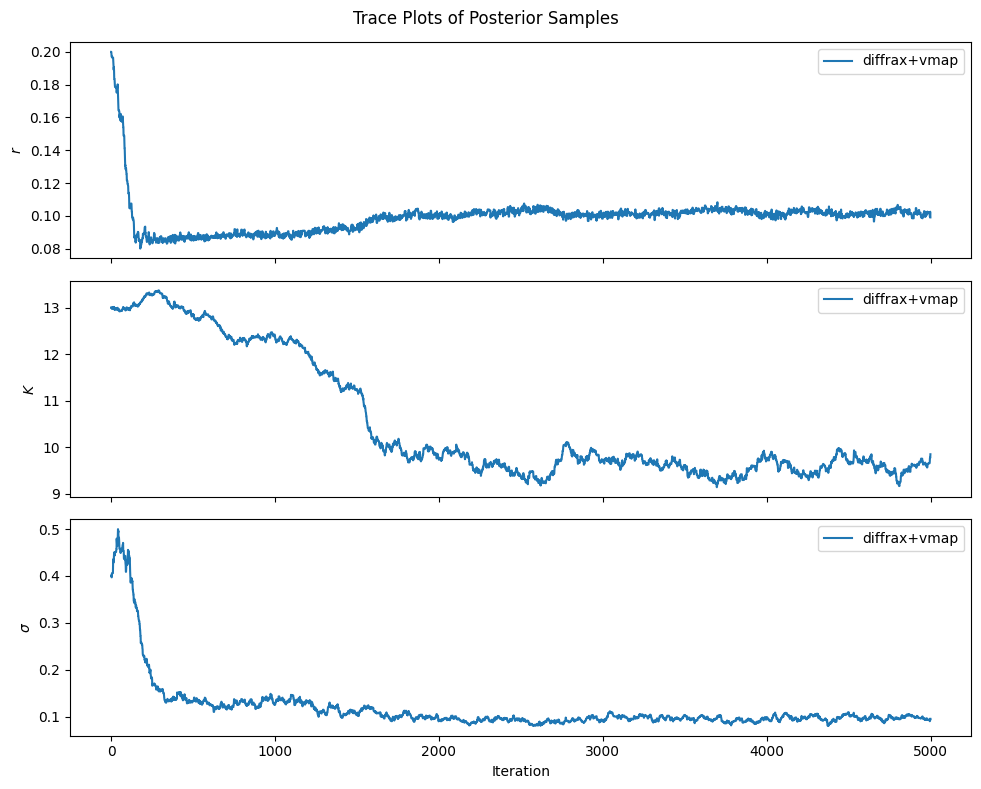

In [ ]:
burn_in = 1000
thining = 5

# samples.shape == (num_samples, 4)
param_names = ["$r$", "$K$", "$\\sigma$"]

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
for i in range(3):
    axs[i].plot(samples_Vectorised[:, i], label="diffrax+vmap")
    #    axs[i].plot(samples_Vectorial[:, i], label = "diffrax_only", linestyle = "dashed")
    # axs[i].plot(samples_Vectorised_JAX[:, i], label = "diffrax+vmap_full_jax")
    #   axs[i].plot(samples_Vectorial_JAX[:, i], label = "diffrax_only_full_jax", linestyle = "dashed")
    axs[i].set_ylabel(param_names[i])
    axs[i].legend()
axs[-1].set_xlabel("Iteration")
fig.suptitle("Trace Plots of Posterior Samples")
plt.tight_layout()
plt.show()

#### **2. Marginal posteriors**

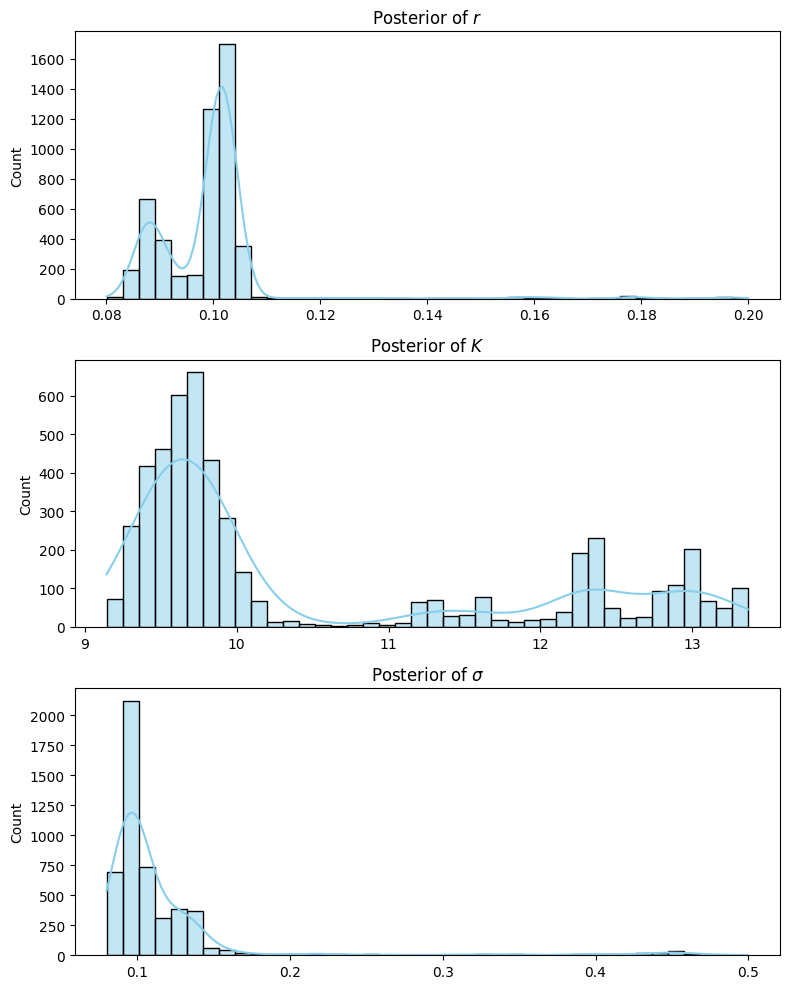

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 10))
axs = axs.flatten()
for i in range(3):
    sns.histplot(
        samples_Vectorised[:, i], kde=True, bins=40, ax=axs[i], color="skyblue"
    )
    axs[i].set_title(f"Posterior of {param_names[i]}")
plt.tight_layout()
plt.show()

#### **3. Joint distributions**

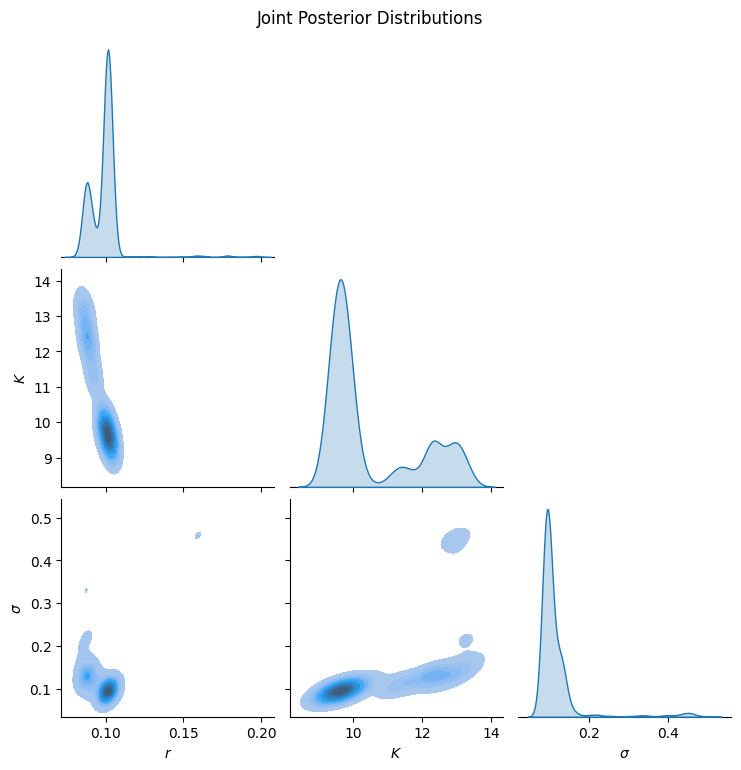

In [ ]:
df_samples = pd.DataFrame(samples_Vectorised, columns=param_names)

sns.pairplot(df_samples, corner=True, kind="kde", plot_kws={"fill": True})
plt.suptitle("Joint Posterior Distributions", y=1.02)
plt.show()

#### **4. Summary Statistics**

In [ ]:
for i, name in enumerate(param_names):
    s = samples_Vectorised[:, i]
    mean = jnp.mean(s)
    median = jnp.median(s)
    ci_lower = jnp.percentile(s, 2.5)
    ci_upper = jnp.percentile(s, 97.5)
    print(
        f"{name}: mean={mean:.3f}, median={median:.3f}, 95% CI=({ci_lower:.3f}, {ci_upper:.3f})"
    )

$r$: mean=0.099, median=0.101, 95% CI=(0.085, 0.107)
$K$: mean=10.513, median=9.783, 95% CI=(9.280, 13.222)
$\sigma$: mean=0.117, median=0.099, 95% CI=(0.085, 0.391)


## **A metamodeling approach using HyperPINN**

Here we use the metamodel (HyperPINN) trained in the notebook `Metamodel_Logistic.ipynb`

#### Sampling from the posterior distribution using the metamodel

In [ ]:
# Warm-up
_ = mh_sampler(theta_init, 20, sigmas, Y, times, key, solver=3)

# Actual run times
samples_Metamodel, acceptance_rate_Metamodel = mh_sampler(
    theta_init, num_samples, sigmas, Y, times, key, solver=3
)
print(
    f"Sampling complete - acceptance rate:\n Vectorised_version: {acceptance_rate_Vectorised:.2%}"
)

Exploring parameter's space: 100%|██████████████████████████████████████████████████████████████████████████| 5000/5000 [01:19<00:00, 63.29it/s]


Sampling complete - acceptance rate:
 Vectorised_version: 56.36%


#### Tracking the convergence of the Markov Chain and comparaison with ground truth solver

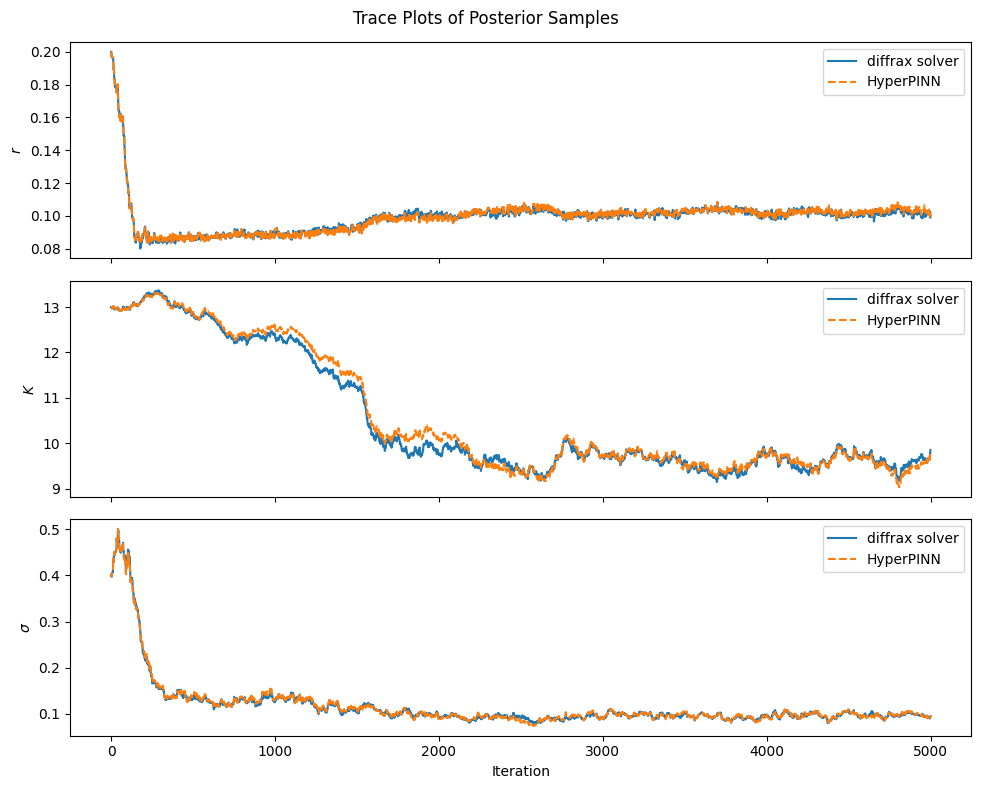

In [ ]:
# samples.shape == (num_samples, 4)
param_names = ["$r$", "$K$", "$\\sigma$"]

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
for i in range(3):
    axs[i].plot(samples_Vectorised[:, i], label="diffrax solver")
    axs[i].plot(samples_Metamodel[:, i], label="HyperPINN", linestyle="dashed")
    axs[i].set_ylabel(param_names[i])
    axs[i].legend()
axs[-1].set_xlabel("Iteration")
fig.suptitle("Trace Plots of Posterior Samples")
plt.tight_layout()
plt.show()

## **Conclusion**

This notebook presents a **unified framework** that combines *mechanistic modeling* and *probabilistic inference* to analyze population dynamics through the **logistic growth ODE**. Using **HyperPINNs**—neural networks trained to solve differential equations—we approximate population trajectories *efficiently*, avoiding repeated numerical ODE solutions. A **Bayesian inference** approach is employed with a *log-normal likelihood* to model noisy observations and informative **priors** based on ecological knowledge. The **posterior distribution** over parameters is explored using a **Metropolis-Hastings MCMC sampler**, with comparisons across solver types.